In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.value = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch, channels, height, width = x.size()

        # Generate query, key, and value
        # query = (
        #     self.query(x).view(batch, -1, width * height).permute(0, 2, 1)
        # )  # (B, N, C//8)
        # key = self.key(x).view(batch, -1, width * height)  # (B, C//8, N)
        # value = self.value(x).view(batch, -1, width * height)  # (B, C, N)

        query = (
            self.query(x).reshape(batch, -1, height * width).permute(0, 2, 1)
        )  # (B, N, C//8)
        key = self.key(x).reshape(batch, -1, height * width)  # (B, C//8, N)
        value = self.value(x).reshape(batch, -1, height * width)  # (B, C, N)
        # Compute attention
        attention = F.softmax(torch.bmm(query, key), dim=-1)  # (B, N, N)
        out = torch.bmm(value, attention.permute(0, 2, 1))  # (B, C, N)

        # Reshape output
        # out = out.view(batch, channels, height, width)
        out = out.reshape(batch, channels, height, width)
        return self.gamma * out + x


class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels):
        super(Generator, self).__init__()
        self.init_size = 7  # MNIST image size reduced by 4
        self.latent_dim = latent_dim

        self.fc = nn.Linear(latent_dim, 128 * self.init_size * self.init_size)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(
                128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            SelfAttention(64),  # Self-Attention layer
            nn.ConvTranspose2d(
                64, img_channels, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.fc(z)
        # out = out.view(out.size(0), 128, self.init_size, self.init_size)
        out = out.reshape(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super(Discriminator, self).__init__()

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            SelfAttention(64),  # Self-Attention layer
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        out = self.conv_blocks(img)
        # out = out.view(out.size(0), -1)
        out = out.reshape(out.size(0), -1)
        validity = self.fc(out)
        return validity

In [1]:
# Hyperparameters
# Hyperparameters
latent_dim = 100
img_channels = 1
batch_size = 64
epochs = 5
lr = 2e-4
# device = torch.device(
#     "mps"
#     if torch.backends.mps.is_available()
#     else "cuda" if torch.cuda.is_available() else "cpu"
# )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
)
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models
generator = Generator(latent_dim, img_channels).to(device)
discriminator = Discriminator(img_channels).to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()

# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)

        # Labels
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Print progress
        print(
            f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] "
            f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
        )

    # Save generated samples
    torchvision.utils.save_image(
        gen_imgs[:25], f"mnist_{epoch}.png", nrow=5, normalize=True
    )

[Epoch 0/50] [Batch 0/938] [D loss: 0.7000] [G loss: 0.7117]
[Epoch 0/50] [Batch 1/938] [D loss: 0.5535] [G loss: 0.7345]
[Epoch 0/50] [Batch 2/938] [D loss: 0.4621] [G loss: 0.8187]
[Epoch 0/50] [Batch 3/938] [D loss: 0.4087] [G loss: 0.8603]
[Epoch 0/50] [Batch 4/938] [D loss: 0.3341] [G loss: 1.0418]
[Epoch 0/50] [Batch 5/938] [D loss: 0.2863] [G loss: 1.2021]
[Epoch 0/50] [Batch 6/938] [D loss: 0.2552] [G loss: 1.3001]
[Epoch 0/50] [Batch 7/938] [D loss: 0.2402] [G loss: 1.3856]
[Epoch 0/50] [Batch 8/938] [D loss: 0.1966] [G loss: 1.5696]
[Epoch 0/50] [Batch 9/938] [D loss: 0.1819] [G loss: 1.6136]
[Epoch 0/50] [Batch 10/938] [D loss: 0.1598] [G loss: 1.7134]
[Epoch 0/50] [Batch 11/938] [D loss: 0.1387] [G loss: 1.8512]
[Epoch 0/50] [Batch 12/938] [D loss: 0.1222] [G loss: 1.9503]
[Epoch 0/50] [Batch 13/938] [D loss: 0.1107] [G loss: 2.0266]
[Epoch 0/50] [Batch 14/938] [D loss: 0.1092] [G loss: 2.1506]
[Epoch 0/50] [Batch 15/938] [D loss: 0.1001] [G loss: 2.1733]
[Epoch 0/50] [Batc

In [2]:
# generate samples

import numpy as np
import matplotlib.pyplot as plt


def generate_samples(generator, num_samples=25, noise_dim=100):
    # Generate random noise
    noise = np.random.normal(0, 1, (num_samples, noise_dim))

    # Generate images from the noise
    generated_images = generator.predict(noise)

    # Rescale images to [0, 1]
    generated_images = 0.5 * generated_images + 0.5

    # Plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


generate_samples(generator, num_samples=25, noise_dim=100)

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[22], line 26
     23     plt.tight_layout()
     24     plt.show()
---> 26 generate_samples(generator, num_samples=25, noise_dim=100)

Cell In[22], line 12, in generate_samples(generator, num_samples, noise_dim)
      9 noise = np.random.normal(0, 1, (num_samples, noise_dim))
     11 # Generate images from the noise
---> 12 generated_images = generator.predict(noise)
     14 # Rescale images to [0, 1]
     15 generated_images = 0.5 * generated_images + 0.5

File ~/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1931, in Module.__getattr__(self, name)
   1929     if name in modules:
   1930         return modules[name]
-> 1931 raise AttributeError(
   1932     f"'{type(self).__name__}' object has no attribute '{name}'"
   1933 )

AttributeError: 'Generator' object has no attribute 'predict'


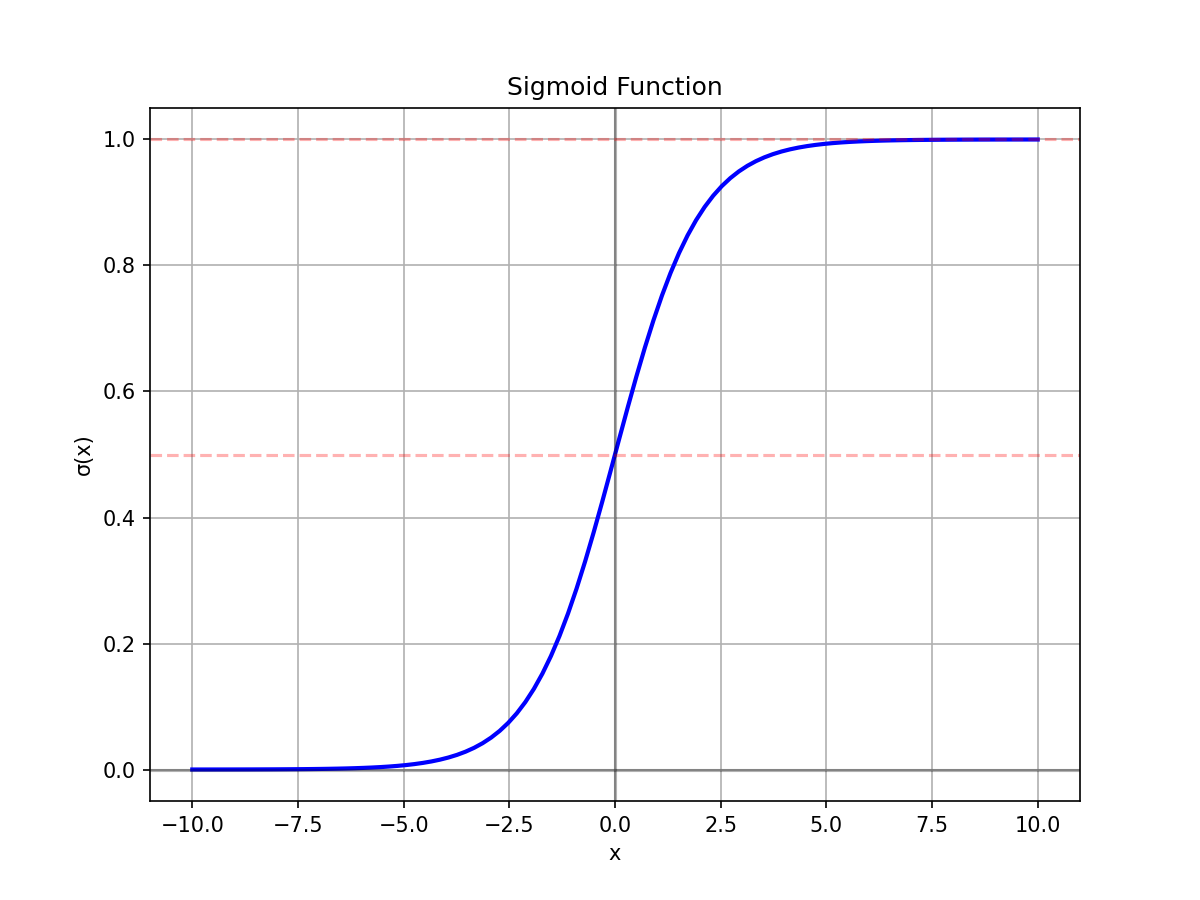

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values
x = np.linspace(-10, 10, 100)


# Calculate sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, sigmoid(x), "b-", linewidth=2)
plt.grid(True)
plt.title("Sigmoid Function")
plt.xlabel("x")
plt.ylabel("σ(x)")

# Add the horizontal and vertical lines at 0
plt.axhline(y=0, color="k", linestyle="-", alpha=0.3)
plt.axvline(x=0, color="k", linestyle="-", alpha=0.3)

# Add horizontal lines at y=0.5 and y=1 for reference
plt.axhline(y=0.5, color="r", linestyle="--", alpha=0.3)
plt.axhline(y=1, color="r", linestyle="--", alpha=0.3)

plt.show()